In [1]:
#load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from nltk.util import ngrams
from functools import reduce
from scipy import stats
from ast import literal_eval
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
#load processed data
df = pd.read_csv('new2_nydf.csv', converters = {
    'description': literal_eval, 'host_about': literal_eval, 
    'bigram_description': literal_eval, 'bigram_host_about': literal_eval})

In [3]:
#delete unnecessary col
df = df.drop('Unnamed: 0', axis = 1)

In [4]:
#take a look at the shape of the dataframe
df.shape

(8427, 45)

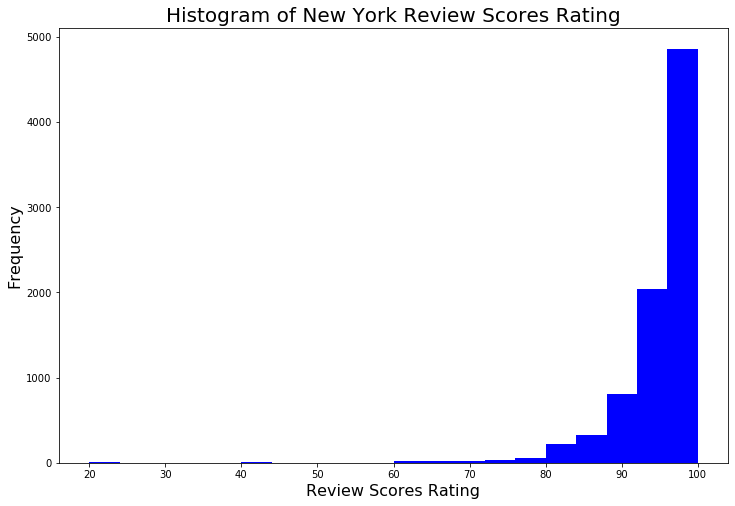

In [5]:
#plot local review score
plt.figure(figsize=(12,8))
plt.hist(df['review_scores_rating'], bins=20, color='b')
plt.title('Histogram of New York Review Scores Rating', fontsize = 20)
plt.xlabel("Review Scores Rating", fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)


plt.savefig('nyreview.png')
plt.show()

In [6]:
print('The mean review scores rating is', df['review_scores_rating'].mean())
print("Percentage of Airbnb home rating less than 90 in New York: {}%".format(round(sum(df.review_scores_rating < 85)/len(df),2)*100))
print("Percentage of Airbnb home rating being 100 in New York:{}%".format(round(sum(df.review_scores_rating == 100)/len(df),2)*100))

The mean review scores rating is 94.79221549780468
Percentage of Airbnb home rating less than 90 in New York: 5.0%
Percentage of Airbnb home rating being 100 in New York:18.0%


In [7]:
df.amenities  #have a look at amenities

0       {TV,"Cable TV",Internet,Wifi,"Air conditioning...
1       {TV,"Cable TV",Wifi,"Air conditioning",Kitchen...
2       {Internet,Wifi,"Air conditioning",Breakfast,"B...
3       {Internet,Wifi,"Air conditioning",Kitchen,"Pai...
4       {TV,"Cable TV",Internet,Wifi,"Air conditioning...
                              ...                        
8422    {TV,Wifi,"Air conditioning",Kitchen,"Paid park...
8423    {TV,Wifi,"Air conditioning",Kitchen,"Pets allo...
8424    {TV,"Cable TV",Wifi,"Air conditioning",Kitchen...
8425    {TV,Wifi,"Air conditioning",Kitchen,"Free stre...
8426    {TV,Wifi,"Air conditioning",Kitchen,"Smoking a...
Name: amenities, Length: 8427, dtype: object

In [8]:
#handling amenities information
df.amenities = df.amenities.replace(to_replace = '["\d\s\-\/{\}]', value='', regex=True)
#a dummy dictionary for ameninties 
#containing all the amenities from all rows
amenities = {}
def itemfind(info):
    start = 0
    for idx, character in enumerate(info):
        if character == ",":
            if info[start:idx] not in amenities:  #each amenity as a key, an empty list as value
                amenities[info[start:idx]] = []
            start = idx+1
    if info[start:] not in amenities: #handling the last piece
            amenities[info[start:]] = []    
df.amenities.apply(lambda x: itemfind(x))

0       None
1       None
2       None
3       None
4       None
        ... 
8422    None
8423    None
8424    None
8425    None
8426    None
Name: amenities, Length: 8427, dtype: object

In [9]:
#binary label: if this amenity exist in this particular row, label as 1, else label as 0
count=0
def label(info):
    global amenities  #the dictionary 
    start = 0
    for idx, character in enumerate(info):
        if character == ",":
            if info[start:idx] in amenities:
                amenities[info[start:idx]].append(1)  #if it exists, label as 1
    global count
    count+=1
    for k,v in amenities.items():
        if len(v) < count: #if it is in the dict but not in the row, label as 0
            amenities[k].append(0)

df.amenities.apply(lambda x: label(x))

0       None
1       None
2       None
3       None
4       None
        ... 
8422    None
8423    None
8424    None
8425    None
8426    None
Name: amenities, Length: 8427, dtype: object

In [10]:
#new dataframe based on amenities dictionary
df2 = pd.DataFrame(amenities)
df = df.reset_index()
df = pd.concat([df, df2], axis=1, sort=False)
keys = list(amenities.keys())

In [11]:
keys  #take a look at what keys we have

['TV',
 'CableTV',
 'Internet',
 'Wifi',
 'Airconditioning',
 'Kitchen',
 'Petsallowed',
 'Freestreetparking',
 'Heating',
 'Familykidfriendly',
 'Smokedetector',
 'Carbonmonoxidedetector',
 'Fireextinguisher',
 'Essentials',
 'Shampoo',
 'Lockonbedroomdoor',
 'hourcheckin',
 'Hangers',
 'Hairdryer',
 'Iron',
 'Laptopfriendlyworkspace',
 'Selfcheckin',
 'Lockbox',
 'Bathtub',
 'Highchair',
 'Stairgates',
 'Children’sbooksandtoys',
 'Pack’nPlaytravelcrib',
 'Hotwater',
 'Microwave',
 'Coffeemaker',
 'Refrigerator',
 'Dishesandsilverware',
 'Cookingbasics',
 'Oven',
 'Stove',
 'Luggagedropoffallowed',
 'Longtermstaysallowed',
 'Buzzerwirelessintercom',
 'Hostgreetsyou',
 'Breakfast',
 'translationmissing:en.hosting_amenity_',
 'Bedlinens',
 'Extrapillowsandblankets',
 'Paidparkingoffpremises',
 'Washer',
 'Dryer',
 'Firstaidkit',
 'Buildingstaff',
 'Privatelivingroom',
 'Privateentrance',
 'Windowguards',
 'Patioorbalcony',
 'Gardenorbackyard',
 'Nostairsorstepstoenter',
 'Showergel',
 '

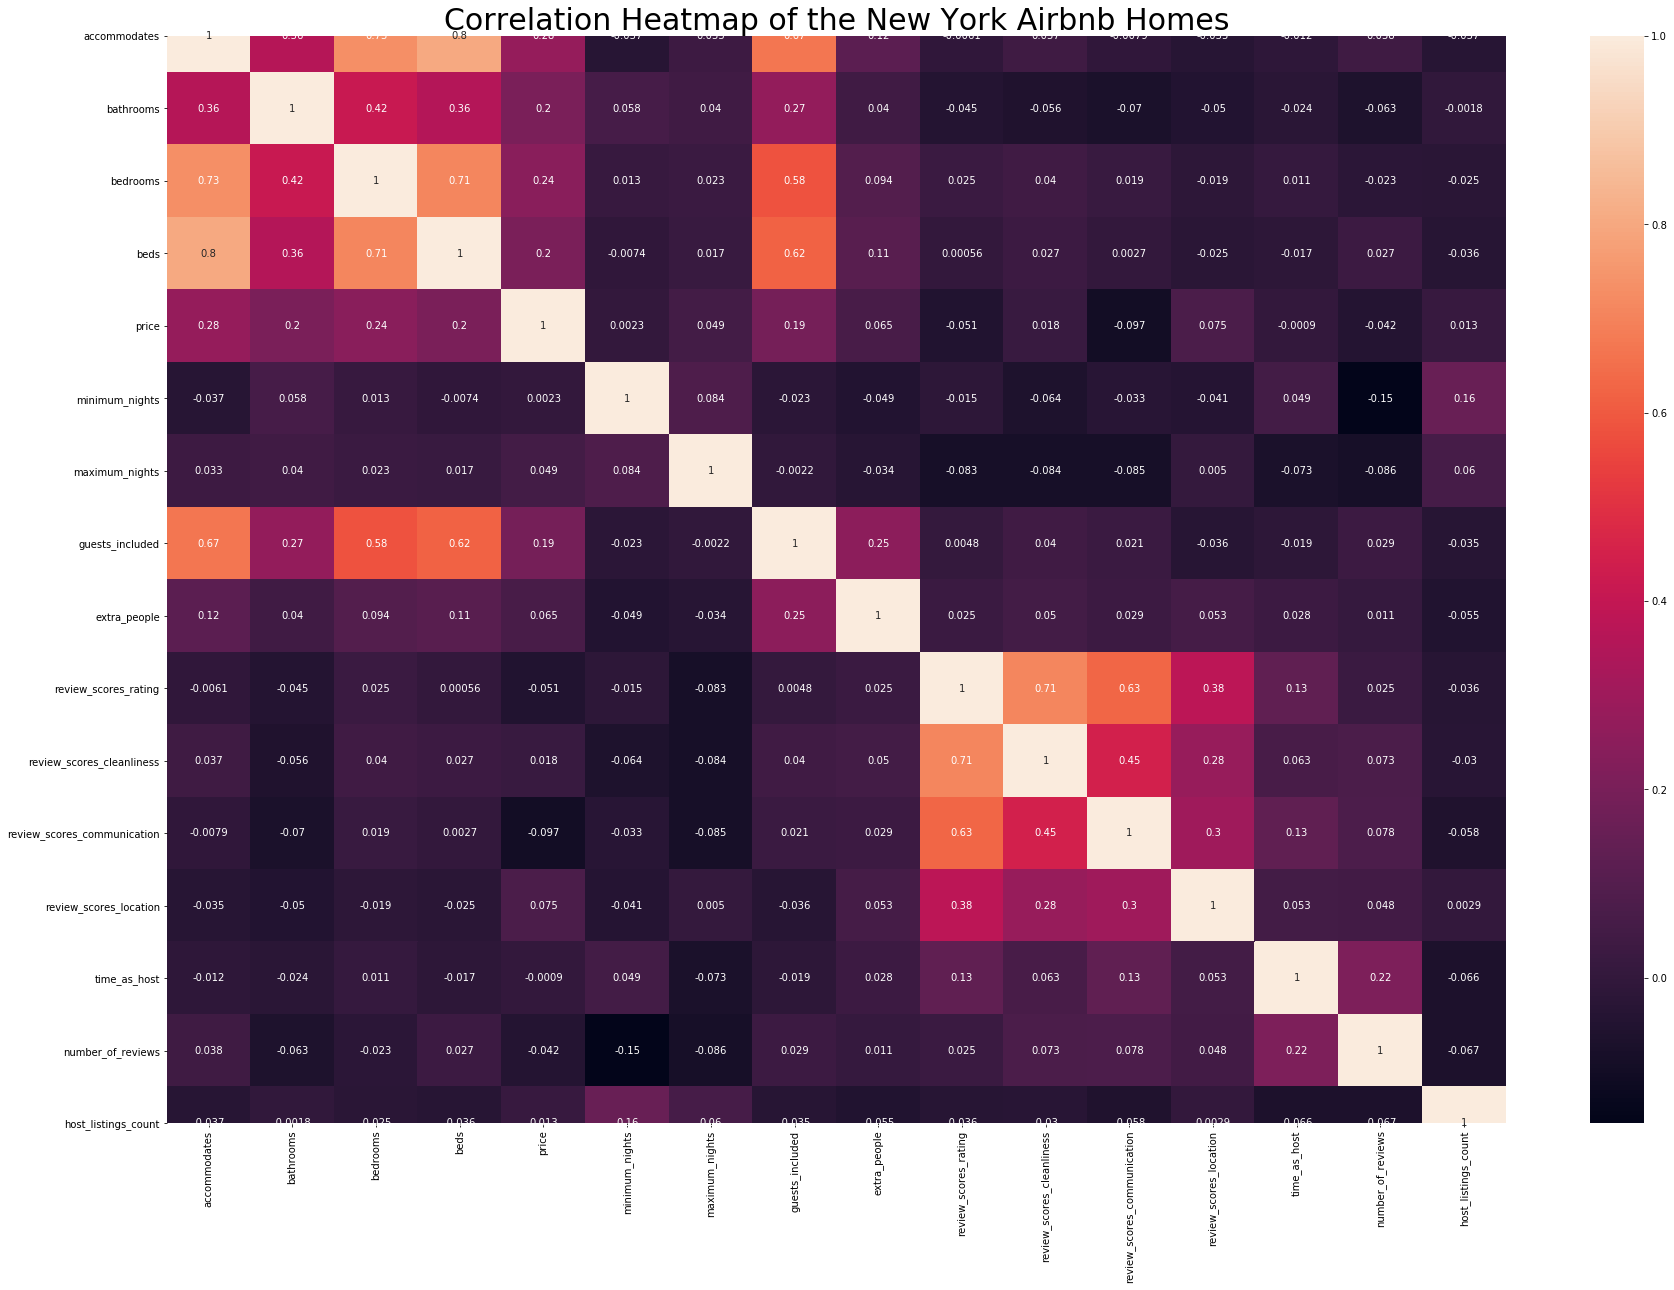

In [12]:
#heatmap
plt.rcParams['figure.figsize'] = (30, 20)
sns.heatmap(df[['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights',              
              'maximum_nights', 'guests_included', 'extra_people','review_scores_rating', 
               'review_scores_cleanliness', 'review_scores_communication',
               'review_scores_location', 'time_as_host', 'number_of_reviews','host_listings_count']].corr(), annot = True)

plt.title('Correlation Heatmap of the New York Airbnb Homes', fontsize = 30)

plt.savefig('heatmapny.png')

In [13]:
#merge the two text info to one text
df['description'] = df['description'].apply(lambda x: ' '.join(x))
df['host_about'] = df['host_about'].apply(lambda x: ' '.join(x))
df['description_host'] = df['description'] + ' ' + df['host_about']

In [14]:
df['description_host']  #have a look at the combined one 

0       urban retreat enjoy floor brownstone wood cera...
1       live like new yorker instead stuffy tiny overp...
2       convenient midtown manhattan location block su...
3       beautiful peaceful healthy home home fun healt...
4       floor brownstone residential street live upsta...
                              ...                        
8422    perfect social distancing best place stay need...
8423    studio style large bedroom perk private space ...
8424    big city life clean entire apartment guest ide...
8425    clean cozy private room male guest room ha sin...
8426    home perfect traveler love hosting meeting new...
Name: description_host, Length: 8427, dtype: object

In [15]:
#select features, target and split the dataset into train/test set
X = df[['description_host', 'accommodates', 'bathrooms', 'beds', 'bedrooms', 'price',
               'guests_included', 'extra_people','minimum_nights',              
              'maximum_nights', 'number_of_reviews', 'review_scores_location',
               'review_scores_cleanliness', 'review_scores_communication', 
               'time_as_host', 'host_response_rate','host_acceptance_rate', 'transit', 'host_has_profile_pic', 
               'host_identity_verified', 
                   'neighbourhood', 'property_type', 'room_type', 'bed_type', 
                   'security_deposit', 'cleaning_fee', 'instant_bookable',
                   'weekly_price', 'host_is_superhost', 'host_response_time'] + keys]
y = df[['review_scores_rating']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

In [16]:
#numeric attributes and pipeline building
numeric_data = ['accommodates', 'bathrooms', 'beds', 'bedrooms', 'price',
               'guests_included', 'extra_people','minimum_nights',              
              'maximum_nights', 'number_of_reviews', 'review_scores_location',
               'review_scores_cleanliness', 'review_scores_communication', 
               'time_as_host', 'host_response_rate','host_acceptance_rate' ]
numeric_pipe = Pipeline([('scale', StandardScaler())])

#categorical attributes and pipeline building 
categorical_data = ['transit', 'host_has_profile_pic', 'host_identity_verified', 
                   'neighbourhood', 'property_type', 'room_type', 'bed_type', 
                   'security_deposit', 'cleaning_fee', 'instant_bookable',
                   'weekly_price', 'host_is_superhost', 'host_response_time'] + keys
categorical_pipe = Pipeline([('onehot', OneHotEncoder(sparse=False, handle_unknown = 'ignore')), 
                     ('varthres', VarianceThreshold(threshold = 0.97*(1-0.97)))])

In [17]:
#text attributes and pipeline building 
text_data = 'description_host'
text_pipe1 = Pipeline([('Count', CountVectorizer(max_features = 10000, min_df = 0.0015, ngram_range = (1,2)))])
text_pipe2 = Pipeline([('Tfid', TfidfVectorizer(max_features = 10000, min_df = 0.0015, ngram_range = (1,2)))])

In [18]:
#build two preprocessors
preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, numeric_data),
        ('cat', categorical_pipe, categorical_data),
        ('text1', text_pipe1, text_data)])
preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, numeric_data),
        ('cat', categorical_pipe, categorical_data),
        ('text2', text_pipe2, text_data)])

### 1. Ridge with bag of words

In [19]:
#create the first pipeline(with bag of words) 
pipe1 = Pipeline(steps=[('preprocessor', preprocessor1),
                      ('regressor', Ridge())])

param_grid = {'regressor__alpha': np.logspace(-1,3, num = 50)}

clf1 = RandomizedSearchCV(pipe1, param_grid, cv = 5, verbose = 15, n_iter = 10, 
                           scoring = 'r2', n_jobs = 4, random_state = 123)

clf1.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   17.7s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   18.0s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   18.0s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   18.0s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   30.3s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   30.4s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   30.5s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   31.0s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   38.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   38.8s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:   40.2s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:   40.3s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   45.9s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:   46.5s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:   47.4s
[Parallel(

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scale',
                                                                                                StandardScaler(copy=True,
                                                                                                

In [20]:
#the parameters
print('optimzed paramters;', clf1.best_params_)

optimzed paramters; {'regressor__alpha': 568.9866029018293}


In [21]:
y_pred = clf1.predict(X_test)

#report the performance metric
train_r2 = round(clf1.score(X_train, y_train), 2)
print("Training set r2:", train_r2)
test_r2 = round(r2_score(y_test, y_pred), 2)
print("Testing set r2:", test_r2)
mse = round(mean_squared_error(y_test, y_pred), 2)
print('Mean square error', mse)
mae = round(mean_absolute_error(y_test, y_pred), 2)
print('Mean absolute error', mae)

Training set r2: 0.74
Testing set r2: 0.68
Mean square error 12.56
Mean absolute error 2.39


In [22]:
#get feature importance
r1importance=[]
temp = clf1.best_estimator_['regressor'].coef_
for i in temp:
    for j in i:
        r1importance.append(j)

p1ohe_label = clf1.best_estimator_['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names()

p1boolean_feature_used = clf1.best_estimator_['preprocessor'].named_transformers_['cat']['varthres'].get_support()

p1cat_used = []

for idx, boolean in enumerate(p1boolean_feature_used):
    if boolean:
        p1cat_used.append(p1ohe_label[idx])


p1voc_used = list(clf1.best_estimator_['preprocessor'].named_transformers_['text1']['Count'].vocabulary_.keys()) 

p1labels = numeric_data+p1cat_used + p1voc_used        

In [23]:
p1ohe_label    #take a look at the encoded categorical features for pipeline1, to understand what the symbols stand for 

array(['x0_False', 'x0_True', 'x1_f', 'x1_t', 'x2_f', 'x2_t',
       'x3_Allerton', 'x3_Alphabet City', 'x3_Annadale', 'x3_Astoria',
       'x3_Bath Beach', 'x3_Battery Park City', 'x3_Bay Ridge',
       'x3_Baychester', 'x3_Bayside', 'x3_Bedford Park',
       'x3_Bedford-Stuyvesant', 'x3_Belmont', 'x3_Bensonhurst',
       'x3_Boerum Hill', 'x3_Brighton Beach', 'x3_Brooklyn',
       'x3_Brooklyn Heights', 'x3_Brooklyn Navy Yard', 'x3_Brownsville',
       'x3_Bushwick', 'x3_Canarsie', 'x3_Carroll Gardens', 'x3_Chelsea',
       'x3_Chinatown', 'x3_City Island', 'x3_Civic Center',
       'x3_Clinton Hill', 'x3_Cobble Hill', 'x3_College Point',
       'x3_Columbia Street Waterfront', 'x3_Concord', 'x3_Concourse',
       'x3_Concourse Village', 'x3_Coney Island', 'x3_Corona',
       'x3_Crotona', 'x3_Crown Heights', 'x3_DUMBO',
       'x3_Ditmars / Steinway', 'x3_Downtown Brooklyn',
       'x3_East Elmhurst', 'x3_East Flatbush', 'x3_East Harlem',
       'x3_East New York', 'x3_East Village'

In [24]:
print('Number of feature importance in the first pipeline: {}'.format(len(r1importance)))
print('Number of labels in the first pipeline: {}'.format(len(p1labels)))

Number of feature importance in the first pipeline: 10052
Number of labels in the first pipeline: 10052


In [25]:
#sort the labels by importance
r1sorted_importance = sorted(list(zip(p1labels, r1importance)), key = lambda x: abs(x[1]), reverse = True)

#sorted labels and sorted feature importance
r1sort_label = []
r1sort_importance = []
for label, value in r1sorted_importance:
    r1sort_label.append(label)
    r1sort_importance.append(value)

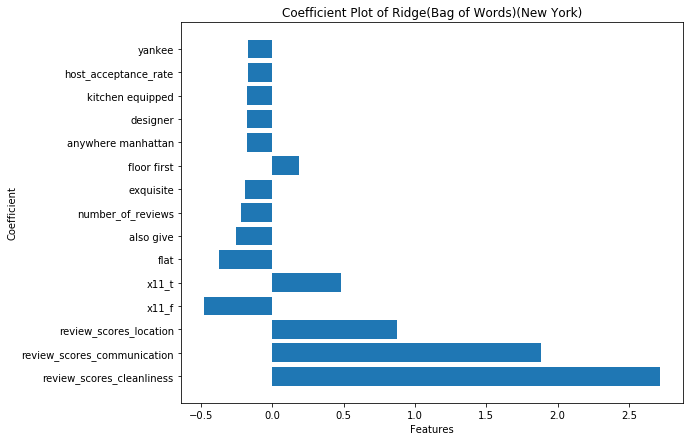

In [26]:
#plot
plt.figure(figsize = (9,7))
plt.barh(r1sort_label[:15], r1sort_importance[:15])
plt.xlabel('Features')
plt.ylabel('Coefficient')  
plt.title('Coefficient Plot of Ridge(Bag of Words)(New York)')
plt.savefig('nyr1.png')

In [27]:
data={'feature':r1sort_label[:15],'ridge(bad of words)':r1sort_importance[:15]}
r1df=pd.DataFrame(data) 
r1df

,feature,ridge(bad of words)
0,review_scores_cleanliness,2.719609
1,review_scores_communication,1.881774
2,review_scores_location,0.874736
3,x11_f,-0.481701
4,x11_t,0.481701
5,flat,-0.373484
6,also give,-0.254097
7,number_of_reviews,-0.223108
8,exquisite,-0.188712
9,floor first,0.188407


### 2. Ridge with tfidf

In [28]:
#create the second pipeline(with tfidf) 
pipe2 = Pipeline(steps=[('preprocessor', preprocessor2),
                      ('regressor', Ridge())])

clf2 = RandomizedSearchCV(pipe2, param_grid, cv = 5, n_iter = 10, n_jobs = 4,
                         scoring = 'r2', random_state = 123, verbose = 15)
clf2.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   10.7s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   10.7s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   10.8s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   10.8s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   19.3s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   19.5s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   19.6s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   19.6s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   28.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   28.2s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:   28.6s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:   28.8s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   37.7s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:   37.8s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:   38.1s
[Parallel(

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scale',
                                                                                                StandardScaler(copy=True,
                                                                                                

In [29]:
print('Optimzed parameters:', clf2.best_params_)

Optimzed parameters: {'regressor__alpha': 23.29951810515372}


In [30]:
y_pred = clf2.predict(X_test)

In [31]:
train_r2 = round(clf2.score(X_train, y_train), 2)
print("Training set r2:", train_r2)
test_r2 = round(r2_score(y_test, y_pred), 2)
print("Testing set r2:", test_r2)
mse = round(mean_squared_error(y_test, y_pred), 2)
print('Mean square error:', mse)
mae = round(mean_absolute_error(y_test, y_pred), 2)
print('Mean absolute error:', mae)

Training set r2: 0.69
Testing set r2: 0.67
Mean square error: 12.73
Mean absolute error: 2.37


In [32]:
r2importance=[]
coeff = clf2.best_estimator_['regressor'].coef_
for i in coeff:
    for j in i:
        r2importance.append(j)

        
p2ohe_label = clf2.best_estimator_['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names()


p2boolean_feature_used = clf2.best_estimator_['preprocessor'].named_transformers_['cat']['varthres'].get_support()

p2cat_used = []

for idx, boolean in enumerate(p2boolean_feature_used):
    if boolean:
        p2cat_used.append(p2ohe_label[idx])

p2voc_used = list(clf2.best_estimator_['preprocessor'].named_transformers_['text2']['Tfid'].vocabulary_.keys()) 

p2labels = numeric_data+p2cat_used + p2voc_used       

In [33]:
p2ohe_label    #take a look at the encoded categorical features for pipeline2, to understand what the symbols stand fo

array(['x0_False', 'x0_True', 'x1_f', 'x1_t', 'x2_f', 'x2_t',
       'x3_Allerton', 'x3_Alphabet City', 'x3_Annadale', 'x3_Astoria',
       'x3_Bath Beach', 'x3_Battery Park City', 'x3_Bay Ridge',
       'x3_Baychester', 'x3_Bayside', 'x3_Bedford Park',
       'x3_Bedford-Stuyvesant', 'x3_Belmont', 'x3_Bensonhurst',
       'x3_Boerum Hill', 'x3_Brighton Beach', 'x3_Brooklyn',
       'x3_Brooklyn Heights', 'x3_Brooklyn Navy Yard', 'x3_Brownsville',
       'x3_Bushwick', 'x3_Canarsie', 'x3_Carroll Gardens', 'x3_Chelsea',
       'x3_Chinatown', 'x3_City Island', 'x3_Civic Center',
       'x3_Clinton Hill', 'x3_Cobble Hill', 'x3_College Point',
       'x3_Columbia Street Waterfront', 'x3_Concord', 'x3_Concourse',
       'x3_Concourse Village', 'x3_Coney Island', 'x3_Corona',
       'x3_Crotona', 'x3_Crown Heights', 'x3_DUMBO',
       'x3_Ditmars / Steinway', 'x3_Downtown Brooklyn',
       'x3_East Elmhurst', 'x3_East Flatbush', 'x3_East Harlem',
       'x3_East New York', 'x3_East Village'

In [34]:
print('Number of feature importance in the second pipeline: {}'.format(len(r2importance)))
print('Number of labels in the second pipeline: {}'.format(len(p2labels)))

Number of feature importance in the second pipeline: 10052
Number of labels in the second pipeline: 10052


In [35]:
r2sorted_importance = sorted(list(zip(p2labels, r2importance)), key = lambda x: abs(x[1]), reverse = True)


r2sort_label = []
r2sort_importance = []
for label, value in r2sorted_importance:
    r2sort_label.append(label)
    r2sort_importance.append(value)

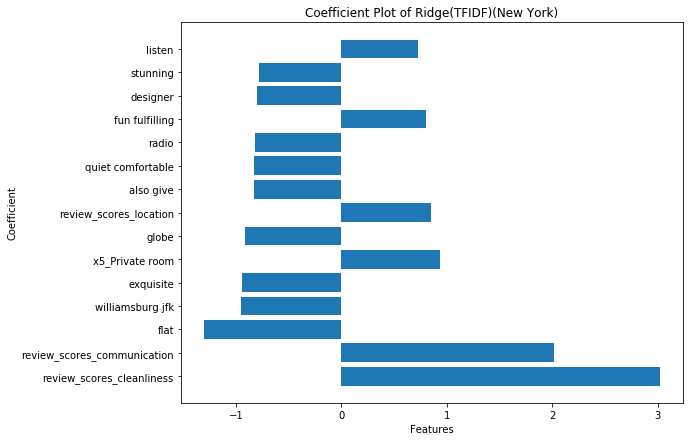

In [36]:
plt.figure(figsize = (9,7))
plt.barh(r2sort_label[:15], r2sort_importance[:15])
plt.xlabel('Features')
plt.ylabel('Coefficient')  
plt.title('Coefficient Plot of Ridge(TFIDF)(New York)')
plt.savefig('nyr2.png')

In [37]:
data={'feature':r2sort_label[:15],'ridge(TFIDF)':r2sort_importance[:15]}
r2df=pd.DataFrame(data) 
r2df

,feature,ridge(TFIDF)
0,review_scores_cleanliness,3.023066
1,review_scores_communication,2.012767
2,flat,-1.306692
3,williamsburg jfk,-0.953300
4,exquisite,-0.939776
5,x5_Private room,0.933641
6,globe,-0.912901
7,review_scores_location,0.844676
8,also give,-0.830433
9,quiet comfortable,-0.826645


### 3. Lasso with bag of words

In [38]:
pipe3 = Pipeline(steps=[('preprocessor', preprocessor1),
                      ('regressor', Lasso())])


param_grid = {'regressor__alpha': np.logspace(-1,3, num = 50)}

clf3 = RandomizedSearchCV(pipe3, param_grid, cv = 5, verbose = 15, n_iter = 10, 
                           scoring = 'r2', n_jobs = 4, random_state = 123)

clf3.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   12.6s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   12.7s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   12.7s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   27.8s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   28.0s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   28.0s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   28.6s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   40.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   40.9s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:   41.1s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:   41.5s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   52.0s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:   52.2s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:   52.4s
[Parallel(

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scale',
                                                                                                StandardScaler(copy=True,
                                                                                                

In [39]:
print('optimzed parameters:', clf3.best_params_)

optimzed parameters: {'regressor__alpha': 0.1}


In [40]:
y_pred = clf3.predict(X_test)

In [41]:
train_r2 = round(clf3.score(X_train, y_train), 2)
print("Training set r2:", train_r2)
test_r2 = round(r2_score(y_test, y_pred), 2)
print("Testing set r2:", test_r2)
mse = round(mean_squared_error(y_test, y_pred), 2)
print('Mean square error:', mse)
mae = round(mean_absolute_error(y_test, y_pred), 2)
print('Mean absolute error:', mae)

Training set r2: 0.66
Testing set r2: 0.65
Mean square error: 13.4
Mean absolute error: 2.43


In [42]:
l1importance= clf3.best_estimator_['regressor'].coef_


l1sorted_Importance = sorted(list(zip(p1labels, l1importance)), key = lambda x: abs(x[1]), reverse = True)


l1sort_label = []
l1sort_importance = []
for label, value in l1sorted_Importance:
    l1sort_label.append(label)
    l1sort_importance.append(value)

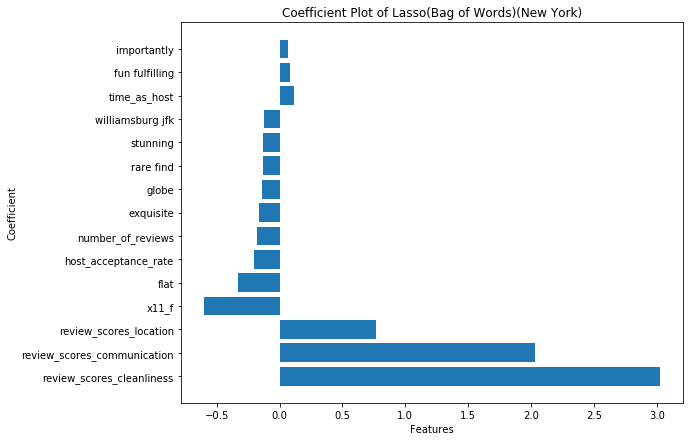

In [43]:
plt.figure(figsize = (9,7))
plt.barh(l1sort_label[:15], l1sort_importance[:15])
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Coefficient Plot of Lasso(Bag of Words)(New York)')
plt.savefig('nyl1.png')

In [44]:
data={'feature':l1sort_label[:15],'lasso(bag of words)':l1sort_importance[:15]}
l1df=pd.DataFrame(data) 
l1df

,feature,lasso(bag of words)
0,review_scores_cleanliness,3.026230
1,review_scores_communication,2.028487
2,review_scores_location,0.763526
3,x11_f,-0.603290
4,flat,-0.329374
5,host_acceptance_rate,-0.199723
6,number_of_reviews,-0.180043
7,exquisite,-0.159862
8,globe,-0.143259
9,rare find,-0.134709


### 4. Lasso with tfidf

In [45]:
pipe4 = Pipeline(steps=[('preprocessor', preprocessor2),
                      ('regressor', Lasso())])

clf4 = RandomizedSearchCV(pipe4, param_grid, cv = 5, n_iter = 10, n_jobs = 4,
                         scoring = 'r2', random_state = 123, verbose = 15)
clf4.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   12.2s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   12.4s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   12.5s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   23.1s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   23.4s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   23.5s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   23.8s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   34.8s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   34.9s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:   34.9s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:   35.6s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   47.3s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:   47.4s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:   47.6s
[Parallel(

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scale',
                                                                                                StandardScaler(copy=True,
                                                                                                

In [46]:
print('optimzed parameters:', clf4.best_params_)

optimzed parameters: {'regressor__alpha': 0.1}


In [47]:
y_pred = clf4.predict(X_test)

In [48]:
train_r2 = round(clf4.score(X_train, y_train), 2)
print("Training set r2:", train_r2)
test_r2 = round(r2_score(y_test, y_pred), 2)
print("Testing set r2:", test_r2)
mse = round(mean_squared_error(y_test, y_pred), 2)
print('Mean square error:', mse)
mae = round(mean_absolute_error(y_test, y_pred), 2)
print('Mean absolute error:', mae)

Training set r2: 0.65
Testing set r2: 0.64
Mean square error: 14.02
Mean absolute error: 2.47


In [49]:
l2importance= clf4.best_estimator_['regressor'].coef_


l2sorted_Importance = sorted(list(zip(p2labels, l2importance)), key = lambda x: abs(x[1]), reverse = True)

l2sort_label = []
l2sort_importance = []
for label, value in l2sorted_Importance:
    l2sort_label.append(label)
    l2sort_importance.append(value)

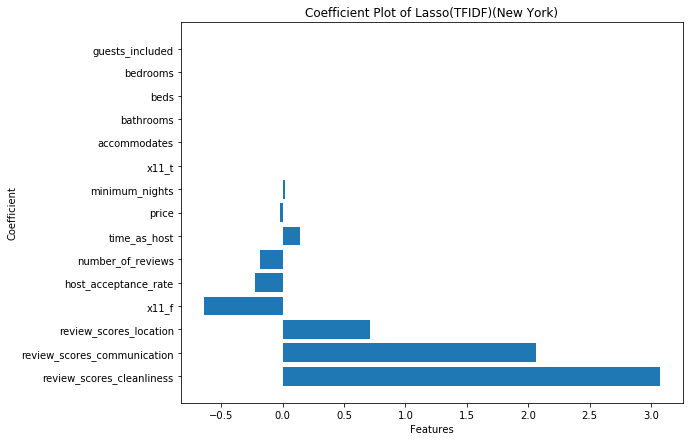

In [50]:
plt.figure(figsize = (9,7))
plt.barh(l2sort_label[:15], l2sort_importance[:15])
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Coefficient Plot of Lasso(TFIDF)(New York)')
plt.savefig('nyl2.png')

In [51]:
data={'feature':l2sort_label[:15],'lasso(TFIDF)':l2sort_importance[:15]}
l2df=pd.DataFrame(data) 
l2df

,feature,lasso(TFIDF)
0,review_scores_cleanliness,3.073856e+00
1,review_scores_communication,2.064565e+00
2,review_scores_location,7.147882e-01
3,x11_f,-6.423078e-01
4,host_acceptance_rate,-2.268486e-01
5,number_of_reviews,-1.797785e-01
6,time_as_host,1.441641e-01
7,price,-2.451104e-02
8,minimum_nights,2.121193e-02
9,x11_t,4.745758e-16


### 5. Random Forest

In [52]:
pipe5 = Pipeline([('preprocessor', preprocessor1),
                  ('regressor', RandomForestRegressor())])

param_grid = {'regressor__n_estimators': np.arange(8,17,2), 
              'regressor__min_samples_split': np.arange(2,6),
             'regressor__min_samples_leaf': np.arange(1,5)}

clf5 = RandomizedSearchCV(pipe5, param_grid, cv = 5, n_iter = 10, n_jobs = 4,
                         scoring = 'r2', random_state = 123, verbose = 15)
clf5.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:  5.7min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  5.8min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:  5.9min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:  5.9min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:  7.1min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:  7.3min
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:  7.6min
[Parallel(

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scale',
                                                                                                StandardScaler(copy=True,
                                                                                                

In [53]:
print('optimized parameters:', clf5.best_params_)

optimized parameters: {'regressor__n_estimators': 16, 'regressor__min_samples_split': 3, 'regressor__min_samples_leaf': 4}


In [54]:
y_pred = clf5.predict(X_test)

In [55]:
train_r2 = round(clf5.score(X_train, y_train), 2)
print("Training set r2:", train_r2)
test_r2 = round(r2_score(y_test, y_pred), 2)
print("Testing set r2:", test_r2)
mse = round(mean_squared_error(y_test, y_pred), 2)
print('Mean square error:', mse)
mae = round(mean_absolute_error(y_test, y_pred), 2)
print('Mean absolute error:', mae)

Training set r2: 0.87
Testing set r2: 0.62
Mean square error: 14.84
Mean absolute error: 2.38


In [56]:
rfimportance = clf5.best_estimator_['regressor'].feature_importances_

rfsorted_importance = sorted(list(zip(p1labels, rfimportance)), key = lambda x: abs(x[1]), reverse = True)

rfsort_label = []
rfsort_importance = []
for label, value in rfsorted_importance:
    rfsort_label.append(label)
    rfsort_importance.append(value)

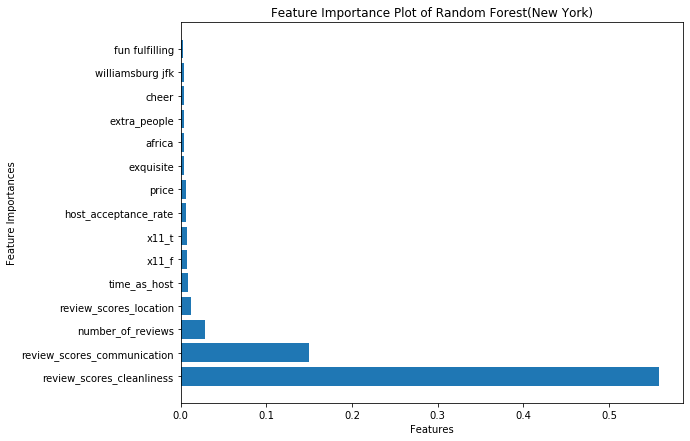

In [57]:
plt.figure(figsize = (9,7))
plt.barh(rfsort_label[:15], rfsort_importance[:15])
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Feature Importance Plot of Random Forest(New York)')
plt.savefig('nyrf.png')   

In [58]:
data={'feature':rfsort_label[:15],'random forest':rfsort_importance[:15]}
rfdf=pd.DataFrame(data) 
rfdf

,feature,random forest
0,review_scores_cleanliness,0.558610
1,review_scores_communication,0.149543
2,number_of_reviews,0.028101
3,review_scores_location,0.011344
4,time_as_host,0.008245
5,x11_f,0.007723
6,x11_t,0.006889
7,host_acceptance_rate,0.006522
8,price,0.005571
9,exquisite,0.004042


### 6. Gradient boosting

In [59]:
pipe6 = Pipeline([('preprocessor', preprocessor1), 
                  ('regressor', GradientBoostingRegressor())])

param_grid = {'regressor__n_estimators': [100, 200, 300, 400, 500],
              'regressor__learning_rate': [0.001, 0.01, 0.1, 0.3],
              'regressor__max_depth': np.arange(3,6),
              'regressor__alpha': np.arange(0,1,0.1)}


clf6 = RandomizedSearchCV(pipe6, param_grid, cv = 5, n_iter = 10, n_jobs = 4,
                         scoring = 'r2', random_state = 123, verbose = 15)
clf6.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:  4.9min
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:  4.9min
[Parallel(

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('scale',
                                                                                                StandardScaler(copy=True,
                                                                                                

In [60]:
print('optimized parameters:', clf6.best_params_)

optimized parameters: {'regressor__n_estimators': 200, 'regressor__max_depth': 4, 'regressor__learning_rate': 0.1, 'regressor__alpha': 0.4}


In [61]:
y_pred = clf6.predict(X_test)

In [62]:
train_r2 = round(clf6.score(X_train, y_train), 2)
print("Training set r2:", train_r2)
test_r2 = round(r2_score(y_test, y_pred), 2)
print("Testing set r2:", test_r2)
mse = round(mean_squared_error(y_test, y_pred), 2)
print('Mean square error:', mse)
mae = round(mean_absolute_error(y_test, y_pred), 2)
print('Mean absolute error:', mae)

Training set r2: 0.85
Testing set r2: 0.66
Mean square error: 13.34
Mean absolute error: 2.31


In [63]:
gbimportance = clf6.best_estimator_['regressor'].feature_importances_

gbsorted_importance = sorted(list(zip(p1labels, gbimportance)), key = lambda x: abs(x[1]), reverse = True)

gbsort_label = []
gbsort_importance = []
for label, value in gbsorted_importance:
    gbsort_label.append(label)
    gbsort_importance.append(value)

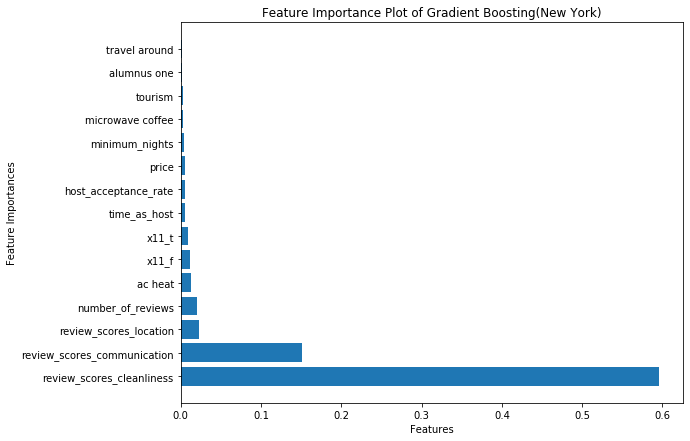

In [70]:
plt.figure(figsize = (9,7))
plt.barh(gbsort_label[:15], gbsort_importance[:15])
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Feature Importance Plot of Gradient Boosting(New York)')
plt.savefig('nygb.png')

In [72]:
data={'feature':gbsort_label[:15],'gradient boosting':gbsort_importance[:15]}
gbdf=pd.DataFrame(data) 
gbdf

,feature,gradient boosting
0,review_scores_cleanliness,0.595844
1,review_scores_communication,0.150562
2,review_scores_location,0.022379
3,number_of_reviews,0.019633
4,ac heat,0.012097
5,x11_f,0.011973
6,x11_t,0.009203
7,time_as_host,0.004842
8,host_acceptance_rate,0.004823
9,price,0.004626


### 7. Important features analysis

In [66]:
data_frames = [r1df,r2df,l1df,l2df,rfdf,gbdf]

In [67]:
#the features ranking top15 in all the models. 
df_merged1 = reduce(lambda left,right: pd.merge(left,right,on='feature',
                                            how='inner'), data_frames)
df_merged1

,feature,ridge(bad of words),ridge(TFIDF),lasso(bag of words),lasso(TFIDF),random forest,gradient boosting
0,review_scores_cleanliness,2.719609,3.023066,3.026230,3.073856,0.558610,0.595844
1,review_scores_communication,1.881774,2.012767,2.028487,2.064565,0.149543,0.150562
2,review_scores_location,0.874736,0.844676,0.763526,0.714788,0.011344,0.022379


In [68]:
#the features ranking top15 in each model. 
df_merged2 = reduce(lambda left,right: pd.merge(left,right,on='feature',
                                            how='outer'), data_frames)
df_merged2

,feature,ridge(bad of words),ridge(TFIDF),lasso(bag of words),lasso(TFIDF),random forest,gradient boosting
0,review_scores_cleanliness,2.719609,3.023066,3.026230,3.073856e+00,0.558610,0.595844
1,review_scores_communication,1.881774,2.012767,2.028487,2.064565e+00,0.149543,0.150562
2,review_scores_location,0.874736,0.844676,0.763526,7.147882e-01,0.011344,0.022379
3,x11_f,-0.481701,NaN,-0.603290,-6.423078e-01,0.007723,0.011973
4,x11_t,0.481701,NaN,NaN,4.745758e-16,0.006889,0.009203
5,flat,-0.373484,-1.306692,-0.329374,NaN,NaN,NaN
6,also give,-0.254097,-0.830433,NaN,NaN,NaN,NaN
7,number_of_reviews,-0.223108,NaN,-0.180043,-1.797785e-01,0.028101,0.019633
8,exquisite,-0.188712,-0.939776,-0.159862,NaN,0.004042,NaN
9,floor first,0.188407,NaN,NaN,NaN,NaN,NaN
